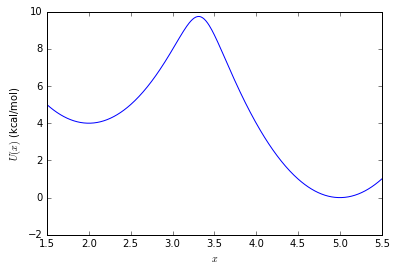

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os, glob

######## Import the two-state potential ########
from twostate import *

dx = 0.01
xmin, xmax = 1.5, 5.5
x = np.arange(xmin, xmax+dx, dx)

plt.figure()
plt.plot(x,U(x))
plt.xlabel('$x$')
plt.ylabel('$U(x)$ (kcal/mol)')
plt.xlim(xmin, xmax)
plt.show()

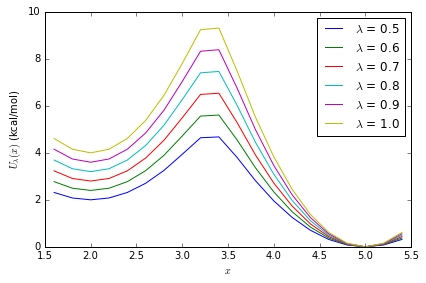

In [2]:
# Let's compile count matrices and compute dTRAM estimates
# for a series of lambda-scaled potentials for a 20-bin landscape

from BinManager import *
nbins = 20
bins = BinManager(nbins=nbins)

# we also will use a fine-grained set of bins for calculating the biases \gamma^(k)
# of each state for each thermodynamic ensemble
fine_grain = 1000  # divide each bin into a 1000 fine-grained bins!
nbins_fine = fine_grain*nbins
bins_fine = BinManager(nbins=nbins_fine)

# known pi^(k) values
lam_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
K = len(lam_values)
pi_k = np.zeros( (K,nbins) )
unbiased_k_index = 5

for k in range(K):
    pi_fine = np.exp(-lam_values[k]*U(bins_fine.centers)/0.596)
    for i in range(nbins):
        pi_k[k,i] = pi_fine[i*fine_grain:(i+1)*fine_grain].sum()
# before we normalize the probabilities for each (k) let's calculate the reweighting factors, gamma^(k)
gamma = np.zeros( pi_k.shape )
for k in range(K):
    gamma[k,:] = pi_k[k,:]/pi_k[unbiased_k_index,:]
# now we normalize the probabilities for each (k)
for k in range(K):
    pi_k[k,:] = pi_k[k,:]/pi_k.sum()

# Let's double-check these populations by plotting the -kT log p_i^(k) for each (k)
plt.figure()
for k in range(K):
    f = -0.596*np.log(pi_k[k,:])
    f = f - f.min()
    plt.plot(bins.centers,f, label='$\lambda$ = %2.1f'%lam_values[k])
plt.xlabel('$x$')
plt.ylabel('$U_{\lambda}(x)$ (kcal/mol)')
plt.xlim(xmin, xmax)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [4]:
from estimators import *

C_k = np.zeros( (K,nbins,nbins) )

# There are two 1e9-step trajectories for each lambda, one starting at 2.0, the other at 5.0
# the *nwrite* of snapshots written in the file is
nwrite = 100
trajfiles = []
ntrials = 5   # save r5-r9 for later

# for k in range(K):
for k in range(0,K):
    lam = lam_values[k]
    for trial in range(ntrials):
        
        C = np.zeros( (nbins,nbins) )

        for init in [2.0, 5.0]:

            infile = '/Volumes/My2TBPassportUltra/projects/long_mcsampler/nsteps1e9_init%2.1f_lam%2.1f_r%d.txt'%(init,lam, trial)
            print 'Loading', infile, '...'
            traj = np.loadtxt(infile)[:,1]
            print 'traj', traj

            # next we assign to bins
            a = bins.bin_index(traj) 
            print 'assigns =', a
            
            assignfile = infile.replace('.txt','.assignments')
            np.save(assignfile, a)
            
            # convert assigns to counts
            for j in range(len(a)-1):
                C[a[j],a[j+1]] += 1

        outfile = 'longtraj-May31/C_k%d_r%d.npy'%(k,trial)                          
        print 'Saving to', outfile, '...'
        np.save(outfile, C)
        
        C_k[k] += C
        
print 'C_k', C_k
outfile = 'longtraj-May31/C_all.npy'                          
print 'Saving to', outfile, '...'
np.save(outfile, C_k)

# save the gamma weights
gammafile = 'longtraj-May31/gamma.npy'                          
print 'Saving gammas to', gammafile, '...'
np.save(gammafile, gamma)



Loading /Volumes/My2TBPassportUltra/projects/long_mcsampler/nsteps1e9_init2.0_lam0.5_r0.txt ...
traj [ 1.97426  2.21992  2.1165  ...,  5.35613  5.35089  5.46401]
assigns = [ 2  3  3 ..., 19 19 19]
Loading /Volumes/My2TBPassportUltra/projects/long_mcsampler/nsteps1e9_init5.0_lam0.5_r0.txt ...
traj [ 4.95     5.21851  5.16518 ...,  4.92112  4.79644  4.48003]
assigns = [17 18 18 ..., 17 16 14]
Saving to longtraj-May31/C_k0_r0.npy ...
Loading /Volumes/My2TBPassportUltra/projects/long_mcsampler/nsteps1e9_init2.0_lam0.5_r1.txt ...
traj [ 1.95001  1.73701  2.10332 ...,  5.34734  5.33671  5.09746]
assigns = [ 2  1  3 ..., 19 19 17]
Loading /Volumes/My2TBPassportUltra/projects/long_mcsampler/nsteps1e9_init5.0_lam0.5_r1.txt ...
traj [ 4.95001  5.15871  5.4511  ...,  4.99156  5.01213  5.0501 ]
assigns = [17 18 19 ..., 17 17 17]
Saving to longtraj-May31/C_k0_r1.npy ...
Loading /Volumes/My2TBPassportUltra/projects/long_mcsampler/nsteps1e9_init2.0_lam0.5_r2.txt ...
traj [ 1.95002  1.78626  1.89604 .

In [3]:
### use the dTRAM estimator in pyemma to estimate the rate
from pyemma.thermo import dtram
from pyemma import msm

lam_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
K = len(lam_values)

# load the gamma weights in
gammafile = 'longtraj-May31/gamma.npy'                          
print 'Loading gammas from', gammafile, '...'
gamma = np.load(gammafile)

nbins = 20
# convert the gammas to biases in units kT
bias = -np.log(gamma)   # (K,N)

# Let's use bootstrapping to get uncertainties
ntrials = 10   # r0 through r9
nbootstraps = 20
trials_for_each_bootstrap = 10

trial_groups = []
for i in range(nbootstraps):
    trial_groups.append( np.random.choice(ntrials, size=trials_for_each_bootstrap, replace=True))
print 'trial groups', trial_groups


# store the results in an array
stride = 100   # <-- data was written to file every 100 snapshots
lagtimes = [100,200,300,400,500,600,700,800,900,1000,1200,1500,2000,5000]

for lagtime in lagtimes:
    
    for g in range(nbootstraps):

        print '**** BOOTSTRAP', g, '****'

        ttrajs = []  # thermodynamic state assignments
        dtrajs = []  # discrete state assignments

        for k in range(1,K):
            lam = lam_values[k]
            for trial in range(trials_for_each_bootstrap):
                trial_index = trial_groups[g][trial]
                for init in [2.0, 5.0]:
                    infile = '/Volumes/My2TBPassportUltra/projects/long_mcsampler/nsteps1e9_init%2.1f_lam%2.1f_r%d.assignments.npy'%(init,lam, trial_index)
                    print 'Loading', infile, '...'
                    assigns = np.load(infile) 
                    dtrajs.append( assigns[::(lagtime/stride)] )
                    ttrajs.append( k*np.ones( assigns.shape, dtype=int)[::(lagtime/stride)] )

        print 'ttrajs', ttrajs
        print 'dtrajs', dtrajs
        print 'bias', bias

        dtram_obj = dtram(ttrajs, dtrajs, bias, 1, unbiased_state=5, maxiter=100000)
        print 'dtram_obj.log_likelihood()', dtram_obj.log_likelihood() 
        # print dtram_obj.count_matrices 
        # print dtram_obj.stationary_distribution 

        for k in range(K):
            kmodel = dtram_obj.models[k]
            print k, lagtime*kmodel.timescales(), 'steps'
            f_kcal = 0.596*kmodel.f
            f_kcal = f_kcal - f_kcal.min()
            print 'f (kcal/mol)', f_kcal
            
            if k == 5:  # the unbiased state
                outfile = 'longtraj-May31/timescales_lag%d_boot%d.txt'%(lagtime,g)
                np.savetxt(outfile, lagtime*kmodel.timescales())
                print 'Wrote:', outfile


Loading gammas from longtraj-May31/gamma.npy ...
trial groups [array([7, 2, 3, 7, 2, 9, 9, 9, 8, 9]), array([3, 9, 3, 3, 9, 6, 9, 4, 0, 1]), array([6, 6, 3, 4, 3, 6, 4, 8, 5, 0]), array([8, 3, 9, 0, 8, 8, 3, 3, 1, 0]), array([1, 4, 7, 7, 5, 5, 8, 6, 5, 4]), array([6, 9, 6, 4, 3, 0, 7, 1, 8, 1]), array([2, 0, 3, 0, 4, 9, 7, 0, 3, 2]), array([7, 1, 8, 8, 5, 0, 3, 4, 8, 2]), array([0, 2, 3, 3, 7, 8, 8, 5, 4, 8]), array([3, 5, 4, 9, 1, 1, 5, 4, 3, 9]), array([2, 8, 9, 6, 7, 7, 2, 4, 2, 2]), array([5, 3, 3, 5, 1, 9, 7, 1, 9, 2]), array([9, 3, 6, 8, 7, 4, 1, 2, 0, 4]), array([5, 7, 7, 0, 3, 7, 6, 6, 0, 8]), array([2, 1, 1, 7, 3, 8, 4, 3, 0, 5]), array([6, 7, 2, 2, 3, 1, 5, 0, 0, 0]), array([8, 3, 5, 0, 6, 5, 0, 9, 9, 7]), array([6, 8, 7, 6, 4, 0, 1, 4, 5, 0]), array([2, 8, 9, 6, 1, 7, 0, 2, 6, 6]), array([0, 2, 6, 0, 2, 7, 8, 8, 3, 6])]
**** BOOTSTRAP 0 ****
Loading /Volumes/My2TBPassportUltra/projects/long_mcsampler/nsteps1e9_init2.0_lam0.6_r7.assignments.npy ...
Loading /Volumes/My2TBPassp

/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/__init__.py:134: UserWarning: Python 2.7 usage is deprecated. Future versions of PyEMMA will not support it. Please upgrade your Python installation.
  "Please upgrade your Python installation.", category=UserWarning)
DTRAM increment=1.8e-15/1.0e-15: 100%|█████████▉| 99604/100000 [00:26<00:00, 3747.57it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 1.77636e-15
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3787.47it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


DTRAM increment=2.2e-11/1.0e-15: 100%|█████████▉| 99775/100000 [00:25<00:00, 3836.78it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 2.13909e-11
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:25<00:00, 3919.93it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=3.3e-11/1.0e-15: 100%|█████████▉| 99891/100000 [00:26<00:00, 3993.59it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 3.24505e-11
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3802.59it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=5.5e-12/1.0e-15: 100%|█████████▉| 99757/100000 [00:25<00:00, 3849.97it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 5.23492e-12
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:25<00:00, 3858.72it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=3.0e-12/1.0e-15: 100%|█████████▉| 99650/100000 [00:26<00:00, 3703.22it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 2.81908e-12
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3767.19it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=2.0e-11/1.0e-15: 100%|█████████▉| 99986/100000 [00:26<00:00, 3531.81it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 2.00959e-11
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3748.67it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=4.4e-10/1.0e-15: 100%|█████████▉| 99530/100000 [00:26<00:00, 3832.17it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 4.06716e-10
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3771.62it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=4.7e-12/1.0e-15: 100%|█████████▉| 99609/100000 [00:26<00:00, 3684.59it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 4.36451e-12
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3702.50it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=3.4e-12/1.0e-15:  99%|█████████▉| 99468/100000 [00:27<00:00, 3755.45it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 3.02691e-12
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:27<00:00, 3709.18it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


DTRAM increment=7.9e-11/1.0e-15: 100%|█████████▉| 99544/100000 [00:25<00:00, 3921.67it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 7.32090e-11
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:25<00:00, 3884.80it/s]


dtrajs [array([ 2,  2,  1, ..., 19, 19, 18]), array([17, 18, 19, ..., 16, 15, 17]), array([ 2,  2,  2, ..., 18, 17, 17]), array([17, 17, 16, ..., 18, 18, 19]), array([ 2,  1,  1, ..., 16, 18, 18]), array([17, 17, 17, ..., 18, 18, 18]), array([ 2,  3,  2, ..., 17, 16, 16]), array([17, 15, 18, ..., 17, 17, 17]), array([ 2,  2,  0, ..., 17, 18, 17]), array([17, 17, 16, ..., 18, 16, 17]), array([ 2,  2,  0, ..., 17, 18, 17]), array([17, 17, 16, ..., 18, 16, 17]), array([ 2,  2,  2, ..., 18, 17, 17]), array([17, 17, 16, ..., 18, 18, 19]), array([ 2,  1,  1, ..., 16, 18, 18]), array([17, 17, 17, ..., 18, 18, 18]), array([ 2,  2,  1, ..., 19, 19, 18]), array([17, 18, 19, ..., 16, 15, 17]), array([ 2,  3,  2, ..., 17, 16, 16]), array([17, 15, 18, ..., 17, 17, 17]), array([ 2,  3,  2, ..., 17, 16, 15]), array([17, 16, 16, ..., 17, 17, 17]), array([ 2,  2,  2, ..., 18, 17, 17]), array([17, 16, 17, ..., 18, 16, 14]), array([ 2,  2,  2, ..., 16, 18, 17]), array([17, 16, 18, ..., 17, 17, 16]), arr


DTRAM increment=7.7e-12/1.0e-15: 100%|█████████▉| 99853/100000 [00:26<00:00, 3716.28it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 7.44116e-12
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3745.48it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=1.1e-11/1.0e-15: 100%|█████████▉| 99796/100000 [00:24<00:00, 4149.30it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 1.07274e-11
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:24<00:00, 4150.76it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=6.2e-11/1.0e-15: 100%|█████████▉| 99895/100000 [00:26<00:00, 3795.05it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 6.07177e-11
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3809.03it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=1.1e-12/1.0e-15: 100%|█████████▉| 99739/100000 [00:27<00:00, 3650.44it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 1.01075e-12
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:27<00:00, 3659.59it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=2.7e-10/1.0e-15: 100%|█████████▉| 99708/100000 [00:26<00:00, 3837.80it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 2.61258e-10
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3766.37it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=3.1e-10/1.0e-15:  99%|█████████▉| 99459/100000 [00:23<00:00, 4224.81it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 2.87738e-10
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:23<00:00, 4260.70it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=5.7e-14/1.0e-15: 100%|█████████▉| 99863/100000 [00:26<00:00, 3777.13it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 5.32907e-14
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3718.26it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=5.0e-11/1.0e-15:  99%|█████████▉| 99315/100000 [00:27<00:00, 3849.02it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 4.41371e-11
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:27<00:00, 3850.93it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


DTRAM increment=2.1e-12/1.0e-15: 100%|█████████▉| 99835/100000 [00:26<00:00, 3755.01it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 2.01261e-12
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3717.03it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


DTRAM increment=6.9e-12/1.0e-15:  99%|█████████▉| 99294/100000 [00:26<00:00, 3735.83it/s]/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/thermo/estimators/DTRAM_estimator.py:261: NotConvergedWarning: dTRAM did not converge: last increment = 5.94191e-12
  pg, stage, self.maxiter, self.maxerr))
100%|██████████| 100000/100000 [00:26<00:00, 3755.96it/s]


dtrajs [array([ 2,  2,  2, ..., 15, 17, 17]), array([17, 18, 19, ..., 17, 17, 15]), array([ 2,  5,  4, ..., 19, 19, 19]), array([17, 17, 18, ..., 16, 17, 19]), array([ 2,  0,  2, ..., 16, 17, 16]), array([17, 18, 18, ..., 14, 16, 14]), array([ 2,  2,  2, ..., 15, 17, 17]), array([17, 18, 19, ..., 17, 17, 15]), array([ 2,  5,  4, ..., 19, 19, 19]), array([17, 17, 18, ..., 16, 17, 19]), array([ 2,  1,  1, ..., 18, 17, 15]), array([17, 19, 17, ..., 18, 16, 15]), array([ 2,  3,  3, ..., 17, 15, 19]), array([17, 15, 18, ..., 19, 17, 16]), array([ 2,  3,  3, ..., 17, 15, 19]), array([17, 15, 18, ..., 19, 17, 16]), array([ 2,  2,  1, ..., 19, 19, 18]), array([17, 18, 19, ..., 16, 15, 17]), array([ 2,  0,  2, ..., 16, 17, 16]), array([17, 18, 18, ..., 14, 16, 14]), array([ 2,  1,  2, ..., 15, 16, 16]), array([17, 15, 16, ..., 16, 17, 17]), array([ 2,  2,  0, ..., 15, 16, 17]), array([17, 16, 16, ..., 17, 18, 18]), array([ 2,  3,  2, ..., 17, 14, 16]), array([17, 17, 18, ..., 17, 17, 17]), arr


100%|██████████| 100000/100000 [00:13<00:00, 7428.90it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


100%|██████████| 100000/100000 [00:20<00:00, 4788.77it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:26<00:00, 3806.47it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3853.29it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:18<00:00, 5398.49it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:27<00:00, 3600.47it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3856.68it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:26<00:00, 3605.40it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


100%|██████████| 100000/100000 [00:26<00:00, 3708.49it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


100%|██████████| 100000/100000 [00:25<00:00, 3921.19it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


100%|██████████| 100000/100000 [00:19<00:00, 5084.80it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3931.91it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:26<00:00, 3766.51it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3920.50it/s]


dtrajs [array([ 2,  2,  4, ..., 18, 17, 17]), array([17, 16, 18, ..., 16, 18, 18]), array([ 2,  1,  0, ..., 17, 19, 17]), array([17, 17, 15, ..., 17, 17, 16]), array([ 2,  1,  0, ..., 17, 19, 17]), array([17, 17, 15, ..., 17, 17, 16]), array([ 2,  2,  1, ..., 15, 16, 17]), array([17, 19, 18, ..., 17, 17, 17]), array([ 2,  1,  0, ..., 18, 18, 19]), array([17, 19, 18, ..., 16, 15, 15]), array([ 2,  1,  0, ..., 17, 19, 17]), array([17, 17, 15, ..., 17, 17, 16]), array([ 2,  2,  1, ..., 17, 16, 17]), array([17, 18, 18, ..., 15, 15, 16]), array([ 2,  2,  1, ..., 17, 16, 17]), array([17, 18, 18, ..., 15, 15, 16]), array([ 2,  2,  1, ..., 15, 16, 17]), array([17, 19, 18, ..., 17, 17, 17]), array([ 2,  3,  4, ..., 17, 16, 15]), array([17, 18, 17, ..., 16, 17, 17]), array([ 2,  2,  2, ..., 18, 19, 17]), array([17, 17, 18, ..., 17, 17, 16]), array([ 2,  3,  4, ..., 16, 16, 18]), array([17, 17, 19, ..., 16, 17, 18]), array([ 2,  3,  4, ..., 16, 16, 18]), array([17, 17, 19, ..., 16, 17, 18]), arr


100%|██████████| 100000/100000 [00:23<00:00, 7244.60it/s]


dtram_obj.log_likelihood() -635179701.701
0 [] steps
f (kcal/mol) [ 2.318271    2.08569134  2.0072714   2.08785589  2.32239292  2.71268821
  3.26151103  3.95794922  4.61161156  4.64401008  3.79452347  2.81249591
  1.95628359  1.25152034  0.70477751  0.31336717  0.07845492  0.          0.0786716
  0.31307651]
1 [  2.13941025e+05   2.39588118e+02   2.35691108e+02   1.16946436e+02
   1.07524350e+02   7.69622192e+01   6.53788947e+01   5.12872975e+01
   4.31039098e+01   3.89175087e+01   3.77672718e+01   3.32060685e+01
   3.23218168e+01   2.99738985e+01   2.69385692e+01   2.68174034e+01
   2.57224248e+01   2.44998051e+01   2.36021574e+01] steps
f (kcal/mol) [ 2.7791852   2.50091659  2.40727137  2.50308086  2.78330439  3.2497674
  3.90511551  4.73670299  5.53499465  5.57457254  4.53857546  3.36146707
  2.33750305  1.49537766  0.84188277  0.37428132  0.09368016  0.
  0.09389685  0.37399071]
2 [  3.94064420e+05   2.05122316e+02   2.04296464e+02   1.02256679e+02
   9.88567030e+01   6.93994210e+


100%|██████████| 100000/100000 [00:23<00:00, 4216.48it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3854.19it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:26<00:00, 3766.21it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:26<00:00, 3837.24it/s]


dtrajs [array([ 2,  4,  0, ..., 17, 19, 19]), array([17, 18, 18, ..., 13, 13, 17]), array([ 2,  3,  4, ..., 17, 16, 15]), array([17, 18, 17, ..., 16, 17, 17]), array([ 2,  2,  1, ..., 17, 16, 16]), array([17, 18, 17, ..., 16, 15, 17]), array([ 2,  2,  1, ..., 17, 16, 17]), array([17, 18, 18, ..., 15, 15, 16]), array([ 2,  0,  2, ..., 16, 16, 18]), array([17, 16, 16, ..., 16, 17, 16]), array([ 2,  1,  0, ..., 17, 19, 17]), array([17, 17, 15, ..., 17, 17, 16]), array([ 2,  2,  1, ..., 15, 16, 17]), array([17, 19, 18, ..., 17, 17, 17]), array([ 2,  4,  0, ..., 17, 19, 19]), array([17, 18, 18, ..., 13, 13, 17]), array([ 2,  2,  1, ..., 17, 16, 17]), array([17, 18, 18, ..., 15, 15, 16]), array([ 2,  2,  1, ..., 17, 16, 17]), array([17, 18, 18, ..., 15, 15, 16]), array([ 2,  0,  2, ..., 15, 16, 16]), array([17, 16, 18, ..., 15, 17, 18]), array([ 2,  2,  3, ..., 15, 14, 16]), array([17, 18, 14, ..., 15, 18, 17]), array([ 2,  4,  2, ..., 16, 14, 13]), array([17, 16, 16, ..., 15, 19, 16]), arr


100%|██████████| 100000/100000 [00:26<00:00, 3781.60it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


100%|██████████| 100000/100000 [00:25<00:00, 3856.06it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3795.34it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3919.73it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:12<00:00, 7950.83it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:12<00:00, 7785.41it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3974.16it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:16<00:00, 5932.90it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3845.15it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:12<00:00, 7757.15it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


100%|██████████| 100000/100000 [00:24<00:00, 4242.30it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


100%|██████████| 100000/100000 [00:13<00:00, 8115.31it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:13<00:00, 7512.85it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:15<00:00, 6543.46it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3956.05it/s]


bias [[ -3.86876946e+00  -3.49217288e+00  -3.36674074e+00  -3.49217067e+00
   -3.86874852e+00  -4.49719831e+00  -5.37755278e+00  -6.49927273e+00
   -7.72949947e+00  -7.78816193e+00  -6.17816358e+00  -4.55133254e+00
   -3.16026819e+00  -2.02361998e+00  -1.14168466e+00  -5.13064380e-01
   -1.36468163e-01  -1.10362759e-02  -1.36468204e-01  -5.13064763e-01]
 [ -3.09320829e+00  -2.79327104e+00  -2.69338466e+00  -2.79326929e+00
   -3.09319192e+00  -3.59384354e+00  -4.29546430e+00  -5.19042369e+00
   -6.17798379e+00  -6.22460032e+00  -4.92753901e+00  -3.62802481e+00
   -2.51842305e+00  -1.61224820e+00  -9.09427102e-01  -4.08644237e-01
   -1.08707270e-01  -8.82108542e-03  -1.08707302e-01  -4.08644537e-01]
 [ -2.31856259e+00  -2.09460454e+00  -2.02003255e+00  -2.09460324e+00
   -2.31855060e+00  -2.69248989e+00  -3.21677631e+00  -3.88626078e+00
   -4.62929059e+00  -4.66398974e+00  -3.68491927e+00  -2.71165736e+00
   -1.88171433e+00  -1.20431516e+00  -6.79173586e-01  -3.05139554e-01
   -8.118171


100%|██████████| 100000/100000 [00:25<00:00, 3983.85it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:15<00:00, 8239.56it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:10<00:00, 7895.85it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:25<00:00, 3924.19it/s]

 [array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]), array(


100%|██████████| 100000/100000 [00:12<00:00, 7713.31it/s]


dtrajs [array([ 2,  1,  0, ..., 17, 19, 19]), array([17, 17, 19, ..., 14, 13, 19]), array([ 2,  2,  1, ..., 15, 16, 19]), array([17, 19, 17, ..., 17, 17, 16]), array([ 2,  3,  4, ..., 14, 16, 16]), array([17, 18, 17, ..., 15, 15, 17]), array([ 2,  0,  2, ..., 17, 16, 16]), array([17, 18, 18, ..., 14, 15, 14]), array([ 2,  2,  4, ..., 13, 16, 17]), array([17, 15, 16, ..., 14, 17, 17]), array([ 2,  1,  3, ..., 17, 19, 15]), array([17, 17, 17, ..., 17, 17, 15]), array([ 2,  1,  2, ..., 16, 16, 17]), array([17, 19, 18, ..., 18, 17, 15]), array([ 2,  1,  0, ..., 17, 19, 19]), array([17, 17, 19, ..., 14, 13, 19]), array([ 2,  0,  2, ..., 17, 16, 16]), array([17, 18, 18, ..., 14, 15, 14]), array([ 2,  0,  2, ..., 17, 16, 16]), array([17, 18, 18, ..., 14, 15, 14]), array([ 2,  1,  2, ..., 13, 16, 17]), array([17, 17, 16, ..., 15, 17, 18]), array([ 2,  3,  4, ..., 15, 14, 16]), array([17, 17, 18, ..., 19, 18, 17]), array([ 2,  3,  3, ..., 17, 14, 17]), array([17, 17, 19, ..., 15, 19, 18]), arr

KeyboardInterrupt: 

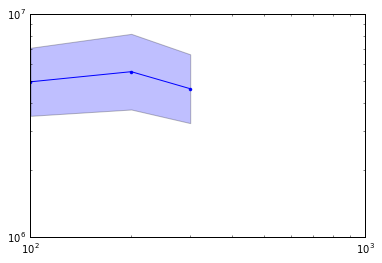

In [5]:
nbootstraps = 18 # 20
lagtimes = [100,200,300] #,400,500,600,700,800,900,1000,1200,1500,2000,5000]

# Load in the implied timescale plot data
its = np.ones( (nbootstraps,len(lagtimes)))
for i in range(len(lagtimes)):    
    lagtime = lagtimes[i]
    for g in range(nbootstraps):
        data = np.loadtxt('longtraj-May31/timescales_lag%d_boot%d.txt'%(lagtime,g))
        its[g,i] = data[0]

its_mean = np.exp(np.log(its).mean(axis=0))
log_its_std = np.log(its).std(axis=0)

plt.figure()
plt.plot(lagtimes, its_mean, '.-') #, ms=markersize, lw=linewidth, label=labels[i])
plt.fill_between(lagtimes, its_mean/np.exp(log_its_std), its_mean*np.exp(log_its_std), facecolor='b', alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.show()




In [31]:
print kmodel.f_full_state
f = kmodel.f_full_state
f = f - f.min()
print f

[  9.03987266   8.27144152   8.01132441   8.27325853   9.0474648
  10.32926989  12.11582134  14.39002297  16.80142062  16.75307001
  13.77870486  10.49107869   7.64564342   5.33034459   3.53192355
   2.24639885   1.47588246   1.21871866   1.47599156   2.24651448]
[  7.82115401   7.05272286   6.79260576   7.05453988   7.82874614
   9.11055124  10.89710269  13.17130431  15.58270196  15.53435135
  12.5599862    9.27236004   6.42692476   4.11162594   2.31320489
   1.02768019   0.2571638    0.           0.2572729    1.02779582]


In [36]:
np.random.choice(10, size=6, replace=True)

array([6, 8, 9, 9, 1, 2])